<a href="https://colab.research.google.com/github/ThePyProgrammer/saylah/blob/master/Creation%20of%20a%20Singlish%20Voice%20Pack%20using%20SIL's%20Pretrained%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of a Singlish Voice Pack
<font size="5">using SIL's Pretrained TTS Model</font>

## Task Description
In this notebook, we will be creating a Voice Pack for the Singaporean Accent, which we intend to use for the [Project Saylah](https://github.com/bettersg/saylah). This project is done by [better.sg](https://better.sg).

### Model Description
The model used is [SIL AI's TTS Singlish Model](https://github.com/sil-ai/tts-singlish) which has been encoded in PyTorch. We intend to convert this into an ONNX model to be used from Vue in an ONNX.js instance. We are referring to the following [video](https://www.youtube.com/watch?v=Vs730jsRgO8) for [converting PyTorch models to ONNX compiled models](https://github.com/elliotwaite/pytorch-to-javascript-with-onnx-js/blob/master/convert_to_onnx.py). 

In [2]:
from IPython.display import HTML
HTML('<iframe width="1120" height="630" src="https://www.youtube.com/embed/Vs730jsRgO8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Set-Up and Imports

### Install Dependencies

This model relies on [Mozilla's Tacotron 2 Pretrained Model](https://github.com/mozilla/TTS/wiki/Released-Models). 

In [5]:
! git clone https://github.com/mozilla/TTS.git
! cd TTS && git checkout 2b970c5 && pip install -r requirements.txt
! pip install soundfile
! apt-get install espeak
! cp -r TTS/* .
!sudo apt-get install festival espeak-ng mbrola
!pip install phonemizer
!pip install Unidecode
!pip install more-itertools

Cloning into 'TTS'...
remote: Enumerating objects: 11984, done.
remote: Total 11984 (delta 0), reused 0 (delta 0), pack-reused 11984
Receiving objects: 100% (11984/11984), 122.87 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (8387/8387), done.
Note: checking out '2b970c5'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2b970c5 Merge pull request #139 from gnosly/fix_185k_model
  Cloning git://github.com/bootphon/phonemizer (to revision master) to /tmp/pip-req-build-3454xjz3
  Running command git clone -q git://github.com/bootphon/phonemizer /tmp/pip-req-build-3454xjz3
     |████████████████████████████████| 4.9 MB 11.1

## Imports
We use PyTorch, NumPy, Soundfile, Matplotlib and some more libraries.

In [6]:
import torch
import numpy as np
import soundfile as sf
from utils.generic_utils import load_config
from utils.audio import AudioProcessor
from models.tacotron import Tacotron
from utils.text import phoneme_to_sequence
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
from more_itertools import flatten

## Modelling

### Download Models

In [7]:
! wget https://sfo2.digitaloceanspaces.com/imda-tts/f_indian.pth.tar
! wget https://raw.githubusercontent.com/sil-ai/tts-singlish/master/config.json

--2021-11-02 12:05:46--  https://sfo2.digitaloceanspaces.com/imda-tts/f_indian.pth.tar
Resolving sfo2.digitaloceanspaces.com (sfo2.digitaloceanspaces.com)... 138.68.32.225
Connecting to sfo2.digitaloceanspaces.com (sfo2.digitaloceanspaces.com)|138.68.32.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84141126 (80M) [application/x-tar]
Saving to: ‘f_indian.pth.tar’

f_indian.pth.tar    100%[===================>]  80.24M  19.1MB/s    in 5.1s    

2021-11-02 12:05:52 (15.6 MB/s) - ‘f_indian.pth.tar’ saved [84141126/84141126]

--2021-11-02 12:05:52--  https://raw.githubusercontent.com/sil-ai/tts-singlish/master/config.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4730 (4.6K) [text/plain]
Saving to: ‘config.json.1’

config.jso

### Load the Model provided by SIL AI

In [10]:
config = load_config("./config.json")
ap = AudioProcessor(**config.audio)
model = Tacotron(61, config.embedding_size, ap.num_freq, ap.num_mels, config.r)
cp = torch.load("./f_indian.pth.tar")
model.load_state_dict(cp['model'])
_ = model.cuda().eval()

 > Setting up Audio Processor...
 | > fft size: 2048, hop length: 275, win length: 1102
 | > Audio Processor attributes.
   | > bits:None
   | > sample_rate:22050
   | > num_mels:80
   | > min_level_db:-100
   | > frame_shift_ms:12.5
   | > frame_length_ms:50
   | > ref_level_db:20
   | > num_freq:1025
   | > power:1.5
   | > preemphasis:0.98
   | > griffin_lim_iters:60
   | > signal_norm:True
   | > symmetric_norm:False
   | > mel_fmin:0
   | > mel_fmax:None
   | > max_norm:1.0
   | > clip_norm:True
   | > do_trim_silence:True
   | > n_fft:2048
   | > hop_length:275
   | > win_length:1102
 | > Number of characters : 61


In [11]:
model

Tacotron(
  (embedding): Embedding(61, 256)
  (encoder): Encoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): Linear(in_features=256, out_features=128, bias=True)
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (cbhg): EncoderCBHG(
      (cbhg): CBHG(
        (relu): ReLU()
        (conv1d_banks): ModuleList(
          (0): BatchNormConv1d(
            (padder): ConstantPad1d(padding=(0, 0), value=0)
            (conv1d): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
            (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
            (activation): ReLU()
          )
          (1): BatchNormConv1d(
            (padder): ConstantPad1d(padding=(0, 1), value=0)
            (conv1d): Conv1d(128, 128, kernel_size=(2,), stride=(1,), bias=False)
            (bn): BatchNorm1d(128, eps=0.001, momentum=0.99, affine=Tru

## Testing The Model
We test the model here, the code is very very very condensed, however.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


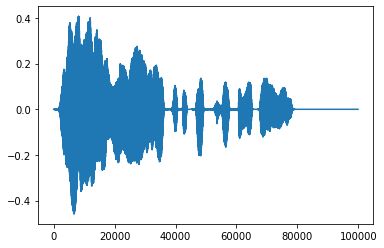

In [12]:
def speak(text = "Hello World this is a test of a Singaporean accent"):
  return np.array(list(flatten([list(ap.inv_spectrogram((model.forward(torch.from_numpy(np.array(phoneme_to_sequence((sentence.strip() + '.').strip(), [config.text_cleaner], config.phoneme_language))).unsqueeze(0).long().cuda()))[1][0].data.cpu().numpy().T))+([0] * 10000) for sentence in text.split(".") if len(sentence) >= 3])))

wav = speak()
plt.plot(wav)

In [16]:
Audio(wav, rate=15000)

In [ ]:
out = io.BytesIO()
ap.save_wav(wav, out)
out.seek(0)
out.read()

A project by [`better.sg`](https://better.sg).

Find Saylah! at [`saylah.sg`](https://saylah.sg).

Find our GitHub Repository at [`bettersg/saylah`](https://github.com/bettersg/saylah).

<img src="https://camo.githubusercontent.com/d999b7c026fc7fe84d58c27d1cc75d9488b78e7c76fb241cdc11a5913a1cecd6/68747470733a2f2f6265747465722e73672f77702d636f6e74656e742f75706c6f6164732f323032302f31322f626574746572776f72646c6f676f40302e35782e706e67" alt="better.sg logo" border="0" width="100" align="right">